In [9]:
# === IMPORTS ===
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [10]:
# === GRAPH GENERATION FUNCTION ===

def generate_netlist(num_nodes=50, num_edges=100, enable_area=True, enable_power=True,
                     enable_wire_count=True, enable_distance=True, seed=None):
    if seed:
        random.seed(seed)
        np.random.seed(seed)
    G = nx.DiGraph()

    num_inputs = math.ceil(math.log2(num_nodes))
    num_outputs = math.ceil(num_inputs / 2)
    input_nodes = [f"IN_{i}" for i in range(num_inputs)]
    output_nodes = [f"OUT_{i}" for i in range(num_outputs)]
    internal_nodes = [f"N_{i}" for i in range(num_nodes)]

    for node in internal_nodes:
        G.add_node(node)
        if enable_area:
            G.nodes[node]['area'] = round(random.uniform(1.0, 5.0), 2)
        if enable_power:
            G.nodes[node]['power'] = round(random.uniform(1.0, 50.0), 2)

    for node in input_nodes + output_nodes:
        G.add_node(node)

    for input_node in input_nodes:
        target = random.choice(internal_nodes)
        G.add_edge(input_node, target)

    for output_node in output_nodes:
        source = random.choice(internal_nodes)
        G.add_edge(source, output_node)

    for node in internal_nodes:
        if G.in_degree(node) == 0:
            source = random.choice(input_nodes + internal_nodes)
            G.add_edge(source, node)
        if G.out_degree(node) == 0:
            target = random.choice(internal_nodes + output_nodes)
            G.add_edge(node, target)

    existing_edges = set(G.edges())
    while len(G.edges()) < num_edges:
        u, v = random.sample(internal_nodes, 2)
        if u != v and (u, v) not in existing_edges:
            G.add_edge(u, v)
            existing_edges.add((u, v))

    for u, v in G.edges():
        if enable_wire_count:
            G.edges[u, v]['wires'] = random.randint(1, 5)
        if enable_distance:
            G.edges[u, v]['distance'] = round(random.uniform(1.0, 10.0), 2)

    return G, input_nodes, output_nodes

In [11]:
# === WIRE METRIC COMPUTATION (MODULAR) ===

def compute_wire_metrics(G, node):
    """
    Computes wire-based metrics for a given node:
    - Average edge distance
    - Total number of wires (incident)
    """
    incident_edges = list(G.edges(node)) + list(G.in_edges(node))
    distances = [G.edges[edge].get("distance", 1.0) for edge in incident_edges]
    wires = [G.edges[edge].get("wires", 1) for edge in incident_edges]

    avg_dist = np.mean(distances) if distances else 0
    total_wires = np.sum(wires) if wires else 0
    return avg_dist, total_wires

In [12]:
# === FEATURE EXTRACTION FUNCTION ===

def extract_node_features(G):
    features = []
    nodes = list(G.nodes())
    for node in nodes:
        power = G.nodes[node].get("power", 0)
        area = G.nodes[node].get("area", 0)
        in_deg = G.in_degree(node)
        out_deg = G.out_degree(node)
        avg_dist, total_wires = compute_wire_metrics(G, node)

        features.append([power, area, in_deg, out_deg, avg_dist, total_wires])
    return np.array(features), nodes


In [13]:
# === KMEANS-BASED PSEUDO LABELING ===

def create_labels_with_kmeans(X, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    return kmeans.fit_predict(X)

In [14]:
# === LOGISTIC REGRESSION TRAINING ===

def train_logistic_regression(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return model

In [15]:
# === PARTITION VISUALIZATION ===

def visualize_partition(G, node_labels, node_list):
    pos = nx.spring_layout(G, seed=42)
    color_map = [node_labels[node_list.index(node)] for node in G.nodes()]
    nx.draw(G, pos, node_color=color_map, cmap='coolwarm', with_labels=True, node_size=400)
    plt.title("Graph Partitioning via Logistic Regression")
    plt.show()

In [16]:
# === PARTITION METRIC EVALUATION ===

def compute_partition_metrics(G, labels, node_list, input_nodes, output_nodes,
                              distance_factor=1.0, gate_delay_factor=0.5):
    label_map = {node: labels[i] for i, node in enumerate(node_list)}

    num_cuts = 0
    total_wire_length = 0

    for u, v in G.edges():
        if label_map.get(u) != label_map.get(v):
            num_cuts += 1
            dist = G.edges[u, v].get("distance", 1.0)
            wires = G.edges[u, v].get("wires", 1)
            total_wire_length += dist * wires

    G_copy = G.copy()
    while not nx.is_directed_acyclic_graph(G_copy):
        try:
            cycle = next(nx.simple_cycles(G_copy))
            min_edge = min(
                ((cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle))),
                key=lambda e: G_copy.edges[e].get("distance", 1)
            )
            G_copy.remove_edge(*min_edge)
        except StopIteration:
            break

    edge_delays = {
        (u, v): (G_copy[u][v].get("distance", 1) ** 2) * distance_factor +
                 G_copy.nodes[v].get("area", 1) * gate_delay_factor
        for u, v in G_copy.edges()
    }

    top_order = list(nx.topological_sort(G_copy))
    longest_path = {node: (0, None) for node in G_copy.nodes()}

    for node in top_order:
        for succ in G_copy.successors(node):
            new_delay = longest_path[node][0] + edge_delays.get((node, succ), 1)
            if new_delay > longest_path[succ][0]:
                longest_path[succ] = (new_delay, node)

    end_node = max(longest_path, key=lambda n: longest_path[n][0])
    critical_delay = longest_path[end_node][0]

    return num_cuts, total_wire_length, critical_delay

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         3

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

Confusion Matrix:
 [[9 0]
 [0 3]]


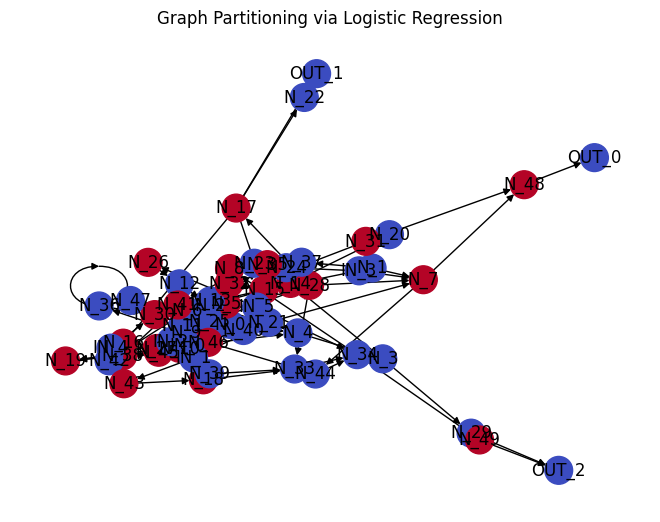

Logistic Regression Partitioning Metrics:
  - Intercluster Cuts: 50
  - Total Wire Length: 751.66
  - Critical Path Length (Delay): 508.87


In [17]:
# === MAIN EXECUTION ===

if __name__ == "__main__":
    G, inputs, outputs = generate_netlist(num_nodes=50, num_edges=100, seed=42)

    X, node_list = extract_node_features(G)
    y = create_labels_with_kmeans(X, n_clusters=2)

    logreg_model = train_logistic_regression(X, y)

    predicted_labels = logreg_model.predict(X)
    visualize_partition(G, predicted_labels, node_list)

    cuts, wire_length, delay = compute_partition_metrics(
        G, predicted_labels, node_list, inputs, outputs
    )

    print("Logistic Regression Partitioning Metrics:")
    print(f"  - Intercluster Cuts: {cuts}")
    print(f"  - Total Wire Length: {wire_length:.2f}")
    print(f"  - Critical Path Length (Delay): {delay:.2f}")

In [ ]:
node_counts = range(50, 1001, 10)

# Lists to store results
all_cuts = []
all_delays = []

# Use fixed seed for reproducibility
seed = 42

# Run analysis for each node count
for num_nodes in node_counts:
    print(f"Analyzing graph with {num_nodes} nodes...")
    
    # Generate network with appropriate number of edges
    # Scale edges to maintain similar density (roughly 2x nodes)
    num_edges = num_nodes * 2
    G, inputs, outputs = generate_netlist(
        num_nodes=num_nodes, 
        num_edges=num_edges,
        seed=seed
    )
    
    # Extract features
    X, node_list = extract_node_features(G)
    
    # Create labels using KMeans
    y = create_labels_with_kmeans(X, n_clusters=2)
    
    # Train logistic regression model
    model = train_logistic_regression(X, y)
    
    # Get predicted labels
    predicted_labels = model.predict(X)
    
    # Compute partition metrics
    cuts, wire_length, delay = compute_partition_metrics(
        G, predicted_labels, node_list, inputs, outputs
    )
    
    # Store results
    all_cuts.append(cuts)
    all_delays.append(delay)
    
    # Print current results
    print(f"  - Nodes: {num_nodes}, Edges: {len(G.edges())}")
    print(f"  - Cuts: {cuts}, Critical Delay: {delay:.2f}")

# Create plots
plt.figure(figsize=(12, 5))

# Plot 1: Cuts vs Node Count
plt.subplot(1, 2, 1)
plt.plot(node_counts, all_cuts, 'bo-', linewidth=2)
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Cuts')
plt.title('Number of Cuts vs. Number of Nodes')
plt.grid(True)

# Plot 2: Critical Path Delay vs Node Count
plt.subplot(1, 2, 2)
plt.plot(node_counts, all_delays, 'ro-', linewidth=2)
plt.xlabel('Number of Nodes')
plt.ylabel('Critical Path Delay')
plt.title('Critical Path Delay vs. Number of Nodes')
plt.grid(True)

plt.tight_layout()
plt.savefig('node_scaling_analysis.png')
plt.show()